In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [35]:
train=pd.read_csv('/content/drive/MyDrive/colab전용/data13/train.csv')
test=pd.read_csv('/content/drive/MyDrive/colab전용/data13/test.csv')

In [36]:
display(train.head())
display(train.shape)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


(415423, 21)

In [27]:
def datainfo(df):
    return pd.DataFrame([(col,df[col].nunique(),df[col].dtype,df[col].isna().sum(),
                          df[col].unique()[:5]) for col in df.columns],
                         columns=['name','nunique','dtype','missing','value :5'])
    
datainfo(train)

,name,nunique,dtype,missing,value :5
0,id,415423,int64,0,"[0, 1, 2, 3, 4]"
1,date,30,object,0,"[2019-09-01, 2019-09-02, 2019-09-03, 2019-09-0..."
2,bus_route_id,613,int64,0,"[4270000, 4280000, 8170000, 8180000, 17010000]"
3,in_out,2,object,0,"[시외, 시내]"
4,station_code,3563,int64,0,"[344, 357, 432, 1579, 1646]"
5,station_name,1961,object,0,"[제주썬호텔, 한라병원, 정존마을, 제주국제공항(600번), 중문관광단지입구]"
6,latitude,3278,float64,0,"[33.4899, 33.48944, 33.48181, 33.50577, 33.255..."
7,longitude,3446,float64,0,"[126.49373, 126.48508, 126.47352, 126.49252, 1..."
8,6~7_ride,47,float64,0,"[0.0, 1.0, 2.0, 4.0, 8.0]"
9,7~8_ride,80,float64,0,"[1.0, 4.0, 17.0, 0.0, 2.0]"


In [58]:
categorical_cols=train.select_dtypes(include='object').columns
numerical_cols=[col for col in train.columns if col not in categorical_cols]

In [59]:
display(categorical_cols)
display(numerical_cols)

Index(['date', 'in_out', 'station_name'], dtype='object')

['id',
 'bus_route_id',
 'station_code',
 'latitude',
 'longitude',
 '6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
 '6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff',
 '18~20_ride']

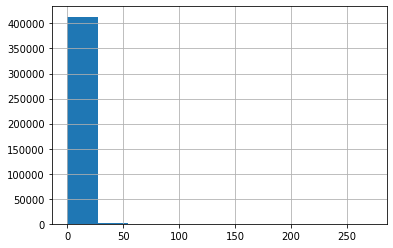

In [77]:
train['18~20_ride'].hist()

In [61]:
train[categorical_cols].describe()

,date,in_out,station_name
count,415423,415423,415423
unique,30,2,1961
top,2019-09-19,시내,한라병원
freq,16030,408500,3125


In [6]:
# 1. train의 9월로 test의 10월을 예측. -> date 함수 뺀다. 
# 1-1. 날짜데이터는 무조건 쓴다? 주말도 빼보고 
# 2. 위.경도 문자열로 합친다.
# 3. 위.경도 다른데 station_name 같다.? -> 길건녀편으로 이름 바꾼다.
# 4. 내생각인데 버스가 많이 내리는곳에서 많이탈수도있고, 많이 안탈수도있다고 생각했다.그래서 takeoff 버리고 한번 해보는것도 괜찮을것같다. columns
# 5. 카테고리를 category_encoders로 바꾸고. pycaret으로 해보려고 한다. -> pycaret의 columns을 읽어들이는게 알아서 잘 순서없는 카테고리로 알아듣는것같다.
# 6. 만약 가능하다면 shap 배운걸로 몇몇 columns들 잘 조작해서 모델을 일반화해보는 과정도 해봐야겠다.

0         2019-09-01
1         2019-09-01
2         2019-09-01
3         2019-09-01
4         2019-09-01
             ...    
415418    2019-09-30
415419    2019-09-30
415420    2019-09-30
415421    2019-09-30
415422    2019-09-30
Name: date, Length: 415423, dtype: object

In [19]:
cols=[col for col in train.columns if 'ride' in col]+\
[col for col in train.columns if 'takeoff' in col]

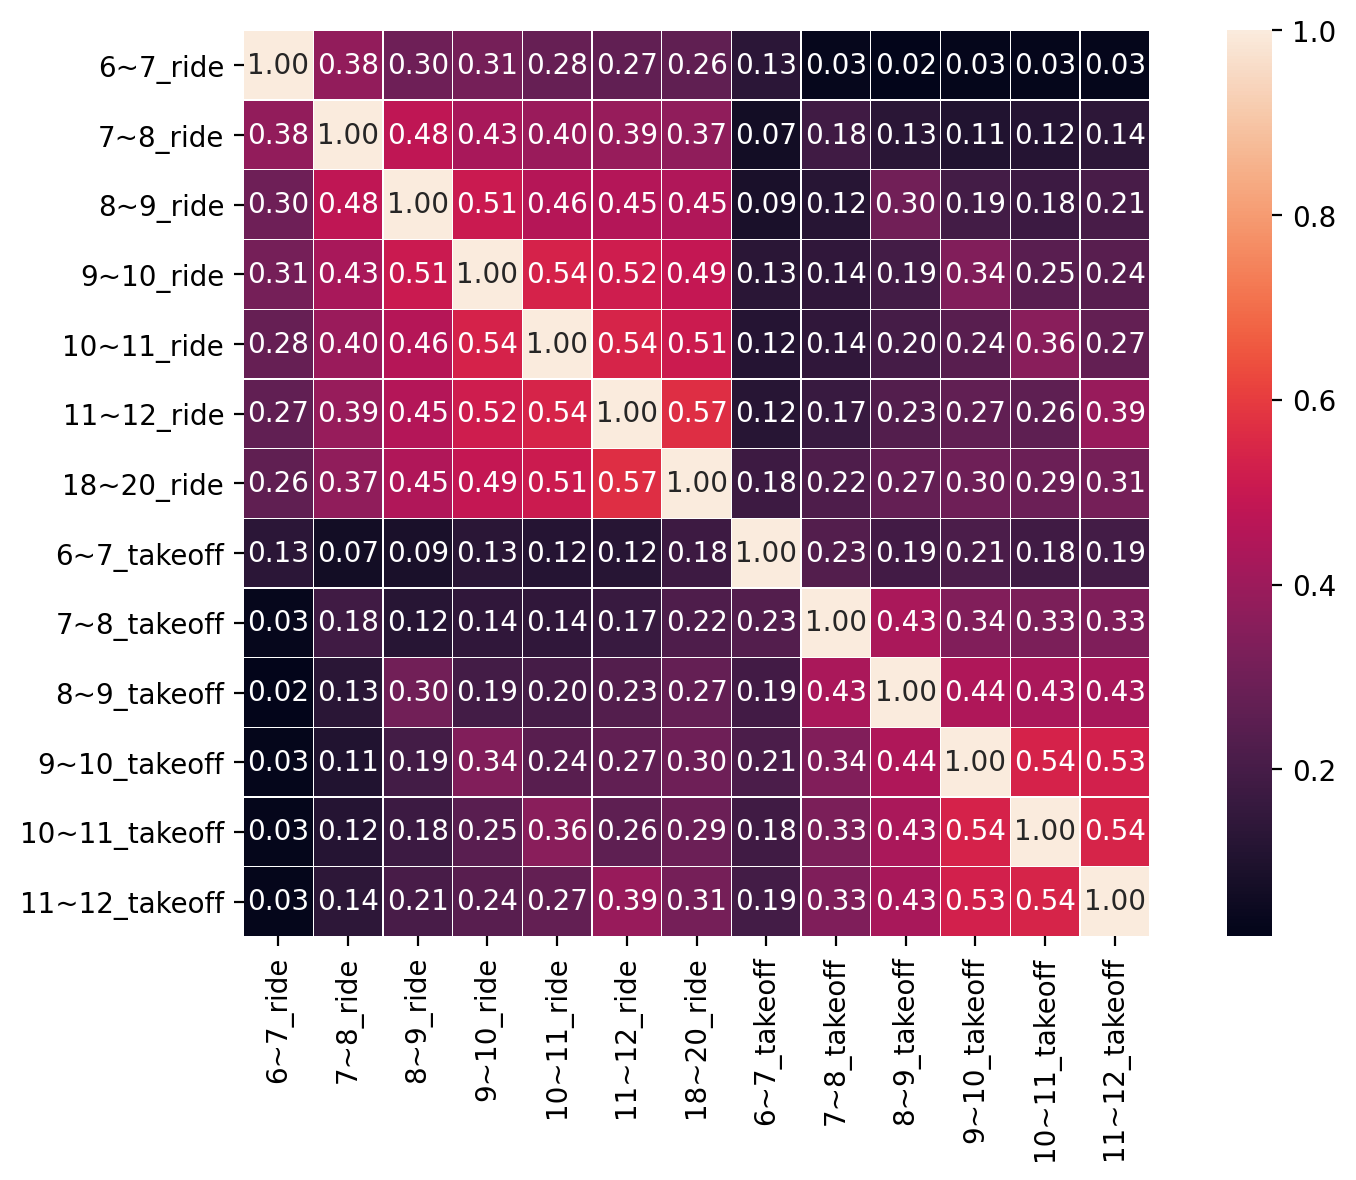

In [25]:
fig,ax=plt.subplots(1,1,figsize=(10,6),dpi=200)

sns.heatmap(train[cols].corr(),annot=True,square=True,fmt='.2f',linewidths=0.1,ax=ax)

plt.show()